# anomaly detection for log prices

**Stock selection**: 48 components of HSI except 0006.HK (large drops due to special dividends) and 1997.HK (only exist starting from 23 Nov 2017).

**Training data**: log (closing) prices $\log S$ in the year 2017.
Testing data: $\log S$ in 2018.

**Aim**: Regarding the distributions of log prices in 2017 as baseline, then test if there are any anomalies in $\log S$ in 2018.

The idea is fed the log prices as inputs to an invertible neural network (invNN). The outputs $\vec{z}$ of the invNN are trained to be (multivariate) Gaussian distributions of $z_i \sim N(0,1)$. When the test data are fed to the trained invNN, if the maximum of the output $\max_i z_i$ reveals a peak (see below), then it is likely that an anomaly has occured in the market of 48 components.

In [1]:
%matplotlib inline

# number of models (ensembles)
n_models = 4 

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

In [ ]:
hsi = pd.read_csv('data_anomaly/^HSI.csv', index_col='Date', parse_dates=['Date',])
assert len(hsi.index.values) == test_samples.shape[0]

In [2]:
yr_train = '2017'
yt_test  = '2018'

def get_data(yr):
    logP_df = pd.read_csv('data_anomaly/logP-{}.csv'.format(yr))
    return logP_df.values[:, 1:] # '1:' => remove the date

def get_train_data():
    return get_data(yr_train)

def get_test_data():
    return get_data(yr_test)

In [3]:
from invNN_base import InvNN_base
import pathlib

class InvNN_anomaly(InvNN_base):
    def __init__(self, in_dim, **kwargs):
        super(InvNN_anomaly, self).__init__(in_dim, **kwargs)
        self.build_encoder()
        # do not need decoder in this case
    def gen_z(test_samples):
        assert test_samples.shape[1] == self.in_dim
        return encoder.predict(test_samples)
    def load_weights(fn_weights):
        self.fn_weights = fn_weights
        if pathlib.Path(fn_weights).is_file():
            encoder.load_weights(fn_weights)
        else:
            assert False, 'weight file does not exist'

in_dim = 48
inv_model = InvNN_anomaly(in_dim=in_dim, inv_mode=1)

Using TensorFlow backend.


In [4]:
# training
train_data = get_train_data()
inv_model.train(
    train_data, train_data,
    batch_size=128, n_epoches=120,
    fn_weights='data_anomaly/anorm-2017-3.invD.weights',
)

Train on 245 samples, validate on 245 samples
Epoch 1/120
245/245 [==============================] - 9s 36ms/step - loss: -129.1431 - val_loss: -146.3147

Epoch 00001: val_loss improved from inf to -146.31472, saving model to data_anomaly/anorm-2017-3.invD.weights
Epoch 2/120
245/245 [==============================] - 0s 916us/step - loss: -147.6384 - val_loss: -152.4628

Epoch 00002: val_loss improved from -146.31472 to -152.46284, saving model to data_anomaly/anorm-2017-3.invD.weights
Epoch 3/120
245/245 [==============================] - 0s 906us/step - loss: -154.2691 - val_loss: -160.1767

Epoch 00003: val_loss improved from -152.46284 to -160.17674, saving model to data_anomaly/anorm-2017-3.invD.weights
Epoch 4/120
245/245 [==============================] - 0s 915us/step - loss: -162.3436 - val_loss: -169.7817

Epoch 00004: val_loss improved from -160.17674 to -169.78173, saving model to data_anomaly/anorm-2017-3.invD.weights
Epoch 5/120
245/245 [==============================] -

245/245 [==============================] - 0s 908us/step - loss: -214.3853 - val_loss: -216.4247

Epoch 00041: val_loss did not improve from -216.63706
Epoch 42/120
245/245 [==============================] - 0s 861us/step - loss: -217.0737 - val_loss: -219.3507

Epoch 00042: val_loss improved from -216.63706 to -219.35073, saving model to data_anomaly/anorm-2017-3.invD.weights
Epoch 43/120
245/245 [==============================] - 0s 882us/step - loss: -219.9819 - val_loss: -221.9975

Epoch 00043: val_loss improved from -219.35073 to -221.99751, saving model to data_anomaly/anorm-2017-3.invD.weights
Epoch 44/120
245/245 [==============================] - 0s 860us/step - loss: -221.6626 - val_loss: -211.8948

Epoch 00044: val_loss did not improve from -221.99751
Epoch 45/120
245/245 [==============================] - 0s 870us/step - loss: -196.5455 - val_loss: -209.6064

Epoch 00045: val_loss did not improve from -221.99751
Epoch 46/120
245/245 [==============================] - 0s 873


Epoch 00084: val_loss improved from -239.73766 to -242.73875, saving model to data_anomaly/anorm-2017-3.invD.weights
Epoch 85/120
245/245 [==============================] - 0s 888us/step - loss: -241.9190 - val_loss: -241.0907

Epoch 00085: val_loss did not improve from -242.73875
Epoch 86/120
245/245 [==============================] - 0s 901us/step - loss: -238.3596 - val_loss: -224.9932

Epoch 00086: val_loss did not improve from -242.73875
Epoch 87/120
245/245 [==============================] - 0s 889us/step - loss: -221.1807 - val_loss: -225.7896

Epoch 00087: val_loss did not improve from -242.73875
Epoch 88/120
245/245 [==============================] - 0s 869us/step - loss: -225.2008 - val_loss: -226.7695

Epoch 00088: val_loss did not improve from -242.73875
Epoch 89/120
245/245 [==============================] - 0s 883us/step - loss: -228.2681 - val_loss: -229.0631

Epoch 00089: val_loss did not improve from -242.73875
Epoch 90/120
245/245 [==============================] - 0

In [ ]:
fn_ = 'data_anomaly/anorm-2017-{}.invD.weights'
test_samples = get_test_data() # logS in 2018

for n in range(n_models):
    col = np.sort(np.abs(inv_model.generate_z(fn_.format(n), test_samples)), axis=1)[:,-1]
    # [:,-1] for max_i(z_i) only
    if n == 0:
        res = pd.DataFrame({'Date': hsi.index, '0': col})
    else:
        res[str(n)] = col
res.to_csv('data_anomaly/res_2018.csv')

(0, 140)

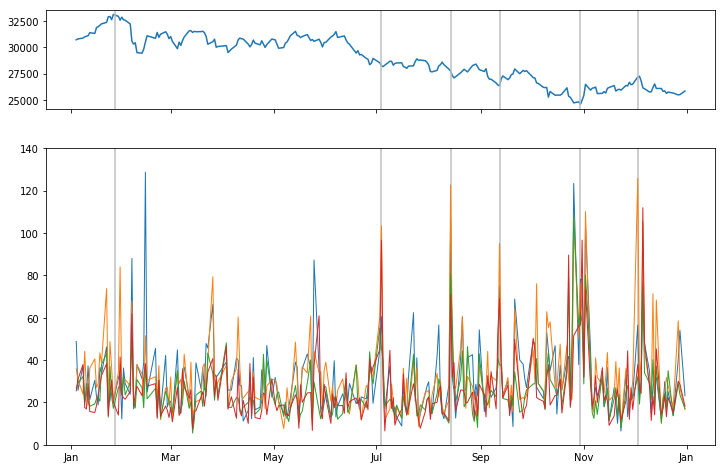

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw = {'height_ratios':[1, 3]})
_ = axs[0].plot(hsi.index.values, hsi.Close.values)
# upper panel is HSI in 2018

res = pd.read_csv('data_anomaly/res_2018.csv', index_col='Date', parse_dates=['Date',])

dates_str = [
    '2018-01-27',
    '2018-07-04',
    '2018-08-14',
    '2018-09-12',
    '2018-10-30',
    '2018-12-03',
]
dates = [pd.to_datetime(_) for _ in dates_str]
for ax in axs:
    for d in dates:
        ax.axvline(x=d, c='#BEBEBE')

for n in range(n_models):
    _ = axs[1].plot(res.index.values, res[str(n)].values, lw=1)

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# lower panel is the outputs max_i(z_i)
axs[1].set_ylim([0, 140])

# Anomalies & events on the corresponding dates

The dates correspond to the grey lines above.

- near the beginning of Feb: HSI reached its historical highest point
- 4 Jul: price dive of mainland real estate & medicine stocks
- 14 Aug: price dive of 2382.HK and other tech companies
- 12 Sept: price dive of medicine stocks
- near 30 Oct: market panic related to China-US trade war
- near 1 Dec: good news from trade war, then the arrest of CFO of Haiwei